In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 함수
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data

path = './ecg_dataset/'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Train과 Test 데이터 분할 (8:2)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, Y.diagnostic_superclass, test_size=0.2, random_state=42)

In [2]:
# device='cpu'

In [3]:
# 레이블 처리
y_train_labels = [set(labels) for labels in y_train_encoded]
y_test_labels = [set(labels) for labels in y_test_encoded]

# 데이터 전처리
X_train = [x for x, labels in zip(X_train, y_train_labels) if len(labels) > 0]
X_train = [torch.from_numpy(x) for x in X_train]  # Convert NumPy arrays to PyTorch tensors
X_train = torch.stack(X_train) if len(X_train) > 0 else None  # 리스트를 PyTorch Tensor로 변환
y_train_labels = [labels for labels in y_train_labels if len(labels) > 0]

X_test = [x for x, labels in zip(X_test, y_test_labels) if len(labels) > 0]
X_test = [torch.from_numpy(x) for x in X_test]  # Convert NumPy arrays to PyTorch tensors
X_test = torch.stack(X_test) if len(X_test) > 0 else None  # 리스트를 PyTorch Tensor로 변환
y_test_labels = [labels for labels in y_test_labels if len(labels) > 0]

# 데이터가 비어있는 경우에 대한 예외 처리
if X_train is not None:
    X_train = X_train.permute(0, 2, 1)

if X_test is not None:
    X_test = X_test.permute(0, 2, 1)

# 전체 레이블 목록 생성
all_labels = list(set(label for labels in y_train_labels for label in labels))

# 레이블을 이진 벡터로 인코딩
def encode_labels(labels, all_labels):
    encoded_labels = [1 if label in labels else 0 for label in all_labels]
    return torch.tensor(encoded_labels, dtype=torch.float32)

y_train_encoded = torch.stack([encode_labels(labels, all_labels) for labels in y_train_labels])
y_test_encoded = torch.stack([encode_labels(labels, all_labels) for labels in y_test_labels])

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

C:\Users\ajmok\AppData\Local\Temp\ipykernel_2008\3745479450.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
C:\Users\ajmok\AppData\Local\Temp\ipykernel_2008\3745479450.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)


In [4]:
X_train.shape

torch.Size([17139, 12, 1000])

In [5]:
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import matplotlib.pyplot as plt

# 1차원 CNN 모델 정의
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=100, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=150, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=150, out_channels=300, kernel_size=10)
        self.relu = nn.ReLU()

        self.pool = nn.MaxPool1d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling 레이어
        self.dropout2 = nn.Dropout(0.5, inplace=False)
        self.fc = nn.Linear(300, num_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, y=None):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout2(x)
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters
num_classes = len(all_labels)
batch_size = 30
epochs = 50
learning_rate = 0.001
k_folds = 5

# K-Fold cross-validation 초기화
skf = MultilabelStratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 폴드 별 각 label의 ROC data를 위한 list
all_fpr = []
all_tpr = []

# Early stopping parameters
patience = 5

Training Fold 1...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 41.74it/s]


Epoch 1, Average Training Loss: 0.4262
Epoch 1, Validation AUC: 0.8868


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.30it/s]


Epoch 2, Average Training Loss: 0.3448
Epoch 2, Validation AUC: 0.9032


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.82it/s]


Epoch 3, Average Training Loss: 0.3191
Epoch 3, Validation AUC: 0.9126


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.19it/s]


Epoch 4, Average Training Loss: 0.3050
Epoch 4, Validation AUC: 0.9190


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.71it/s]


Epoch 5, Average Training Loss: 0.2975
Epoch 5, Validation AUC: 0.9196


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.20it/s]


Epoch 6, Average Training Loss: 0.2892
Epoch 6, Validation AUC: 0.9257


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.65it/s]


Epoch 7, Average Training Loss: 0.2830
Epoch 7, Validation AUC: 0.9259


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.97it/s]


Epoch 8, Average Training Loss: 0.2761
Epoch 8, Validation AUC: 0.9233


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.79it/s]


Epoch 9, Average Training Loss: 0.2723
Epoch 9, Validation AUC: 0.9268


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.45it/s]


Epoch 10, Average Training Loss: 0.2688
Epoch 10, Validation AUC: 0.9292


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.40it/s]


Epoch 11, Average Training Loss: 0.2662
Epoch 11, Validation AUC: 0.9317


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.84it/s]


Epoch 12, Average Training Loss: 0.2617
Epoch 12, Validation AUC: 0.9323


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.04it/s]


Epoch 13, Average Training Loss: 0.2588
Epoch 13, Validation AUC: 0.9325


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.22it/s]


Epoch 14, Average Training Loss: 0.2579
Epoch 14, Validation AUC: 0.9335


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.42it/s]


Epoch 15, Average Training Loss: 0.2528
Epoch 15, Validation AUC: 0.9345


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.52it/s]


Epoch 16, Average Training Loss: 0.2507
Epoch 16, Validation AUC: 0.9345


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.75it/s]


Epoch 17, Average Training Loss: 0.2503
Epoch 17, Validation AUC: 0.9349


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.04it/s]


Epoch 18, Average Training Loss: 0.2467
Epoch 18, Validation AUC: 0.9356


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.78it/s]


Epoch 19, Average Training Loss: 0.2439
Epoch 19, Validation AUC: 0.9351


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.19it/s]


Epoch 20, Average Training Loss: 0.2428
Epoch 20, Validation AUC: 0.9359


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.78it/s]


Epoch 21, Average Training Loss: 0.2399
Epoch 21, Validation AUC: 0.9359


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.29it/s]


Epoch 22, Average Training Loss: 0.2399
Epoch 22, Validation AUC: 0.9376


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.66it/s]


Epoch 23, Average Training Loss: 0.2357
Epoch 23, Validation AUC: 0.9372


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.11it/s]


Epoch 24, Average Training Loss: 0.2344
Epoch 24, Validation AUC: 0.9370


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.54it/s]


Epoch 25, Average Training Loss: 0.2316
Epoch 25, Validation AUC: 0.9387


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.64it/s]


Epoch 26, Average Training Loss: 0.2280
Epoch 26, Validation AUC: 0.9370


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.67it/s]


Epoch 27, Average Training Loss: 0.2290
Epoch 27, Validation AUC: 0.9385


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.36it/s]


Epoch 28, Average Training Loss: 0.2271
Epoch 28, Validation AUC: 0.9364


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.06it/s]


Epoch 29, Average Training Loss: 0.2248
Epoch 29, Validation AUC: 0.9371


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.08it/s]


Epoch 30, Average Training Loss: 0.2250
Epoch 30, Validation AUC: 0.9379
Early stopping at epoch 30
Best AUC: 0.9387 (Epoch 30)
Training Fold 2...


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 144.14it/s]


Epoch 1, Average Training Loss: 0.4320
Epoch 1, Validation AUC: 0.8785


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 150.94it/s]


Epoch 2, Average Training Loss: 0.3412
Epoch 2, Validation AUC: 0.9021


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.40it/s]


Epoch 3, Average Training Loss: 0.3219
Epoch 3, Validation AUC: 0.9137


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.05it/s]


Epoch 4, Average Training Loss: 0.3071
Epoch 4, Validation AUC: 0.9200


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.98it/s]


Epoch 5, Average Training Loss: 0.2971
Epoch 5, Validation AUC: 0.9236


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.20it/s]


Epoch 6, Average Training Loss: 0.2918
Epoch 6, Validation AUC: 0.9258


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.82it/s]


Epoch 7, Average Training Loss: 0.2829
Epoch 7, Validation AUC: 0.9272


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.15it/s]


Epoch 8, Average Training Loss: 0.2788
Epoch 8, Validation AUC: 0.9288


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.95it/s]


Epoch 9, Average Training Loss: 0.2745
Epoch 9, Validation AUC: 0.9328


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.03it/s]


Epoch 10, Average Training Loss: 0.2701
Epoch 10, Validation AUC: 0.9326


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.90it/s]


Epoch 11, Average Training Loss: 0.2676
Epoch 11, Validation AUC: 0.9339


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.46it/s]


Epoch 12, Average Training Loss: 0.2639
Epoch 12, Validation AUC: 0.9355


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.44it/s]


Epoch 13, Average Training Loss: 0.2604
Epoch 13, Validation AUC: 0.9345


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.13it/s]


Epoch 14, Average Training Loss: 0.2584
Epoch 14, Validation AUC: 0.9336


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.09it/s]


Epoch 15, Average Training Loss: 0.2552
Epoch 15, Validation AUC: 0.9375


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.21it/s]


Epoch 16, Average Training Loss: 0.2508
Epoch 16, Validation AUC: 0.9377


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.30it/s]


Epoch 17, Average Training Loss: 0.2488
Epoch 17, Validation AUC: 0.9383


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.69it/s]


Epoch 18, Average Training Loss: 0.2487
Epoch 18, Validation AUC: 0.9368


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.94it/s]


Epoch 19, Average Training Loss: 0.2461
Epoch 19, Validation AUC: 0.9362


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 146.88it/s]


Epoch 20, Average Training Loss: 0.2419
Epoch 20, Validation AUC: 0.9379


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.18it/s]


Epoch 21, Average Training Loss: 0.2407
Epoch 21, Validation AUC: 0.9359


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.91it/s]


Epoch 22, Average Training Loss: 0.2394
Epoch 22, Validation AUC: 0.9374
Early stopping at epoch 22
Best AUC: 0.9383 (Epoch 22)
Training Fold 3...


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.55it/s]


Epoch 1, Average Training Loss: 0.4202
Epoch 1, Validation AUC: 0.8809


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.58it/s]


Epoch 2, Average Training Loss: 0.3371
Epoch 2, Validation AUC: 0.8982


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.56it/s]


Epoch 3, Average Training Loss: 0.3158
Epoch 3, Validation AUC: 0.9051


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.67it/s]


Epoch 4, Average Training Loss: 0.3038
Epoch 4, Validation AUC: 0.9155


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.77it/s]


Epoch 5, Average Training Loss: 0.2931
Epoch 5, Validation AUC: 0.9195


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.64it/s]


Epoch 6, Average Training Loss: 0.2845
Epoch 6, Validation AUC: 0.9228


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.31it/s]


Epoch 7, Average Training Loss: 0.2799
Epoch 7, Validation AUC: 0.9247


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.44it/s]


Epoch 8, Average Training Loss: 0.2755
Epoch 8, Validation AUC: 0.9255


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.76it/s]


Epoch 9, Average Training Loss: 0.2695
Epoch 9, Validation AUC: 0.9271


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.63it/s]


Epoch 10, Average Training Loss: 0.2674
Epoch 10, Validation AUC: 0.9278


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.73it/s]


Epoch 11, Average Training Loss: 0.2650
Epoch 11, Validation AUC: 0.9289


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.75it/s]


Epoch 12, Average Training Loss: 0.2593
Epoch 12, Validation AUC: 0.9300


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.89it/s]


Epoch 13, Average Training Loss: 0.2561
Epoch 13, Validation AUC: 0.9309


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.57it/s]


Epoch 14, Average Training Loss: 0.2519
Epoch 14, Validation AUC: 0.9303


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.27it/s]


Epoch 15, Average Training Loss: 0.2520
Epoch 15, Validation AUC: 0.9307


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.59it/s]


Epoch 16, Average Training Loss: 0.2492
Epoch 16, Validation AUC: 0.9304


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.95it/s]


Epoch 17, Average Training Loss: 0.2439
Epoch 17, Validation AUC: 0.9329


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.42it/s]


Epoch 18, Average Training Loss: 0.2422
Epoch 18, Validation AUC: 0.9321


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.02it/s]


Epoch 19, Average Training Loss: 0.2418
Epoch 19, Validation AUC: 0.9345


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.24it/s]


Epoch 20, Average Training Loss: 0.2399
Epoch 20, Validation AUC: 0.9323


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.64it/s]


Epoch 21, Average Training Loss: 0.2364
Epoch 21, Validation AUC: 0.9324


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.42it/s]


Epoch 22, Average Training Loss: 0.2353
Epoch 22, Validation AUC: 0.9329


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.53it/s]


Epoch 23, Average Training Loss: 0.2324
Epoch 23, Validation AUC: 0.9353


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 156.32it/s]


Epoch 24, Average Training Loss: 0.2310
Epoch 24, Validation AUC: 0.9330


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.45it/s]


Epoch 25, Average Training Loss: 0.2284
Epoch 25, Validation AUC: 0.9352


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 154.97it/s]


Epoch 26, Average Training Loss: 0.2277
Epoch 26, Validation AUC: 0.9320


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 155.52it/s]


Epoch 27, Average Training Loss: 0.2248
Epoch 27, Validation AUC: 0.9348


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:02<00:00, 157.47it/s]


Epoch 28, Average Training Loss: 0.2218
Epoch 28, Validation AUC: 0.9339
Early stopping at epoch 28
Best AUC: 0.9353 (Epoch 28)
Training Fold 4...


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.74it/s]


Epoch 1, Average Training Loss: 0.4402
Epoch 1, Validation AUC: 0.8766


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.44it/s]


Epoch 2, Average Training Loss: 0.3485
Epoch 2, Validation AUC: 0.8996


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.92it/s]


Epoch 3, Average Training Loss: 0.3233
Epoch 3, Validation AUC: 0.9090


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.80it/s]


Epoch 4, Average Training Loss: 0.3115
Epoch 4, Validation AUC: 0.9156


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.73it/s]


Epoch 5, Average Training Loss: 0.3024
Epoch 5, Validation AUC: 0.9167


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 153.25it/s]


Epoch 6, Average Training Loss: 0.2943
Epoch 6, Validation AUC: 0.9201


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.82it/s]


Epoch 7, Average Training Loss: 0.2868
Epoch 7, Validation AUC: 0.9216


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.11it/s]


Epoch 8, Average Training Loss: 0.2802
Epoch 8, Validation AUC: 0.9275


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.82it/s]


Epoch 9, Average Training Loss: 0.2749
Epoch 9, Validation AUC: 0.9277


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.54it/s]


Epoch 10, Average Training Loss: 0.2711
Epoch 10, Validation AUC: 0.9312


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:03<00:00, 152.49it/s]


Epoch 11, Average Training Loss: 0.2686
Epoch 11, Validation AUC: 0.9335


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:03<00:00, 150.12it/s]


Epoch 12, Average Training Loss: 0.2657
Epoch 12, Validation AUC: 0.9337


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:03<00:00, 152.66it/s]


Epoch 13, Average Training Loss: 0.2596
Epoch 13, Validation AUC: 0.9338


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.71it/s]


Epoch 14, Average Training Loss: 0.2573
Epoch 14, Validation AUC: 0.9340


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.68it/s]


Epoch 15, Average Training Loss: 0.2561
Epoch 15, Validation AUC: 0.9360


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.59it/s]


Epoch 16, Average Training Loss: 0.2515
Epoch 16, Validation AUC: 0.9352


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:03<00:00, 152.47it/s]


Epoch 17, Average Training Loss: 0.2493
Epoch 17, Validation AUC: 0.9365


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 153.90it/s]


Epoch 18, Average Training Loss: 0.2475
Epoch 18, Validation AUC: 0.9373


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.78it/s]


Epoch 19, Average Training Loss: 0.2451
Epoch 19, Validation AUC: 0.9352


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.11it/s]


Epoch 20, Average Training Loss: 0.2420
Epoch 20, Validation AUC: 0.9354


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 153.35it/s]


Epoch 21, Average Training Loss: 0.2406
Epoch 21, Validation AUC: 0.9356


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:03<00:00, 152.27it/s]


Epoch 22, Average Training Loss: 0.2388
Epoch 22, Validation AUC: 0.9377


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:03<00:00, 152.49it/s]


Epoch 23, Average Training Loss: 0.2362
Epoch 23, Validation AUC: 0.9350


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.90it/s]


Epoch 24, Average Training Loss: 0.2362
Epoch 24, Validation AUC: 0.9363


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.64it/s]


Epoch 25, Average Training Loss: 0.2325
Epoch 25, Validation AUC: 0.9380


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 158.55it/s]


Epoch 26, Average Training Loss: 0.2322
Epoch 26, Validation AUC: 0.9360


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 158.37it/s]


Epoch 27, Average Training Loss: 0.2301
Epoch 27, Validation AUC: 0.9374


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 154.04it/s]


Epoch 28, Average Training Loss: 0.2281
Epoch 28, Validation AUC: 0.9383


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.95it/s]


Epoch 29, Average Training Loss: 0.2297
Epoch 29, Validation AUC: 0.9374


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.30it/s]


Epoch 30, Average Training Loss: 0.2263
Epoch 30, Validation AUC: 0.9368


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.15it/s]


Epoch 31, Average Training Loss: 0.2236
Epoch 31, Validation AUC: 0.9381


Epoch 32: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 156.18it/s]


Epoch 32, Average Training Loss: 0.2231
Epoch 32, Validation AUC: 0.9377


Epoch 33: 100%|█████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 157.15it/s]


Epoch 33, Average Training Loss: 0.2186
Epoch 33, Validation AUC: 0.9372
Early stopping at epoch 33
Best AUC: 0.9383 (Epoch 33)
Training Fold 5...


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 125.75it/s]


Epoch 1, Average Training Loss: 0.4378
Epoch 1, Validation AUC: 0.8716


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.69it/s]


Epoch 2, Average Training Loss: 0.3438
Epoch 2, Validation AUC: 0.8925


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.76it/s]


Epoch 3, Average Training Loss: 0.3251
Epoch 3, Validation AUC: 0.9037


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.41it/s]


Epoch 4, Average Training Loss: 0.3085
Epoch 4, Validation AUC: 0.9073


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.87it/s]


Epoch 5, Average Training Loss: 0.3007
Epoch 5, Validation AUC: 0.9163


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.21it/s]


Epoch 6, Average Training Loss: 0.2922
Epoch 6, Validation AUC: 0.9200


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.87it/s]


Epoch 7, Average Training Loss: 0.2864
Epoch 7, Validation AUC: 0.9178


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.31it/s]


Epoch 8, Average Training Loss: 0.2800
Epoch 8, Validation AUC: 0.9230


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.00it/s]


Epoch 9, Average Training Loss: 0.2748
Epoch 9, Validation AUC: 0.9256


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.12it/s]


Epoch 10, Average Training Loss: 0.2701
Epoch 10, Validation AUC: 0.9259


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.43it/s]


Epoch 11, Average Training Loss: 0.2684
Epoch 11, Validation AUC: 0.9270


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.60it/s]


Epoch 12, Average Training Loss: 0.2631
Epoch 12, Validation AUC: 0.9286


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.20it/s]


Epoch 13, Average Training Loss: 0.2613
Epoch 13, Validation AUC: 0.9317


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.36it/s]


Epoch 14, Average Training Loss: 0.2561
Epoch 14, Validation AUC: 0.9296


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.09it/s]


Epoch 15, Average Training Loss: 0.2553
Epoch 15, Validation AUC: 0.9324


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.42it/s]


Epoch 16, Average Training Loss: 0.2528
Epoch 16, Validation AUC: 0.9294


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.82it/s]


Epoch 17, Average Training Loss: 0.2481
Epoch 17, Validation AUC: 0.9323


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.64it/s]


Epoch 18, Average Training Loss: 0.2463
Epoch 18, Validation AUC: 0.9328


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.85it/s]


Epoch 19, Average Training Loss: 0.2438
Epoch 19, Validation AUC: 0.9318


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.43it/s]


Epoch 20, Average Training Loss: 0.2412
Epoch 20, Validation AUC: 0.9336


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.04it/s]


Epoch 21, Average Training Loss: 0.2391
Epoch 21, Validation AUC: 0.9336


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.48it/s]


Epoch 22, Average Training Loss: 0.2371
Epoch 22, Validation AUC: 0.9341


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.37it/s]


Epoch 23, Average Training Loss: 0.2347
Epoch 23, Validation AUC: 0.9340


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 130.65it/s]


Epoch 24, Average Training Loss: 0.2344
Epoch 24, Validation AUC: 0.9348


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.85it/s]


Epoch 25, Average Training Loss: 0.2309
Epoch 25, Validation AUC: 0.9331


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.44it/s]


Epoch 26, Average Training Loss: 0.2289
Epoch 26, Validation AUC: 0.9357


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.23it/s]


Epoch 27, Average Training Loss: 0.2301
Epoch 27, Validation AUC: 0.9339


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.65it/s]


Epoch 28, Average Training Loss: 0.2278
Epoch 28, Validation AUC: 0.9333


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.41it/s]


Epoch 29, Average Training Loss: 0.2244
Epoch 29, Validation AUC: 0.9330


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.27it/s]


Epoch 30, Average Training Loss: 0.2229
Epoch 30, Validation AUC: 0.9346


Epoch 31: 100%|█████████████████████████████████████████████████████████████████████| 457/457 [00:03<00:00, 131.90it/s]


Epoch 31, Average Training Loss: 0.2207
Epoch 31, Validation AUC: 0.9344
Early stopping at epoch 31
Best AUC: 0.9357 (Epoch 31)


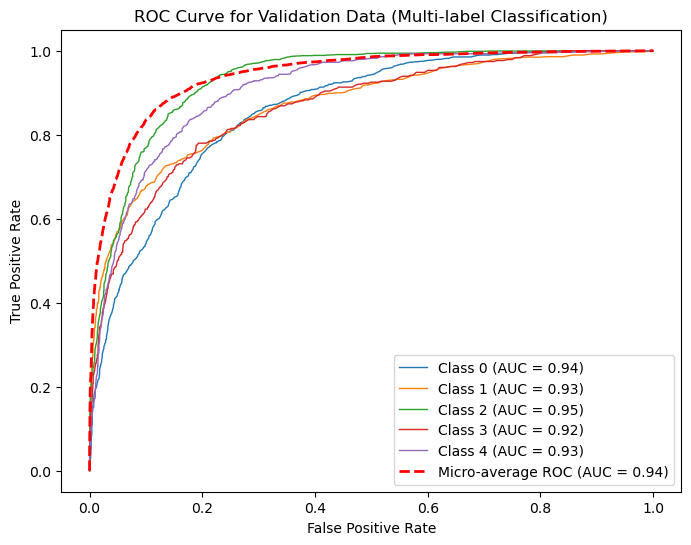

In [6]:
# 폴드 별 학습 및 평가
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
    print(f"Training Fold {fold + 1}...")
    
    # model, optimizer, loss function 초기화
    model = CNN1D(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()  # Since we are using sigmoid activation in the model

    # 현재 폴드에 대한 데이터 로더 재정의
    train_loader = DataLoader(TensorDataset(X_train[train_idx].to(device).float(), y_train_tensor[train_idx].to(device).float()), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_train[val_idx].to(device).float(), y_train_tensor[val_idx].to(device).float()), batch_size=batch_size, shuffle=False)

    best_auc = 0.0
    no_improvement_epochs = 0
    
    # tqdm을 통해 학습 과정 표시
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)
        average_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}, Average Training Loss: {average_train_loss:.4f}")

        # Validation set evaluation
        model.eval()
        y_scores = []
        y_true = []
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                for batch_x, batch_y in val_loader:
                    output = model(batch_x)
                    output = nn.functional.sigmoid(output)
                    y_scores.append(output.cpu().numpy())
                    y_true.append(batch_y.cpu().numpy())

        y_scores = np.vstack(y_scores)
        y_true = np.vstack(y_true)
        
        # 각 label 별로 ROC curve 계산
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            all_fpr.append(fpr[i])
            all_tpr.append(tpr[i])

        # validation set에 대한 AUC score 계산
        auc_score = roc_auc_score(y_true, y_scores)

        print(f"Epoch {epoch + 1}, Validation AUC: {auc_score:.4f}")

        # AUC score 확인 후 갱신
        if auc_score > best_auc:
            best_auc = auc_score
            no_improvement_epochs = 0
        else:
            # Early stopping 확인
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Best AUC: {best_auc:.4f} (Epoch {epoch + 1})")

# 각 label 별로 ROC curve를 plot
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Micro-average ROC curve 계산 및 plot
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
micro_auc = auc(micro_fpr, micro_tpr)
plt.plot(micro_fpr, micro_tpr, color='red', linestyle='--', lw=2, label=f'Micro-average ROC (AUC = {micro_auc:.2f})')

# Labels 과 legend 추가
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Data (Multi-label Classification)')
plt.legend(loc='lower right')
plt.show()

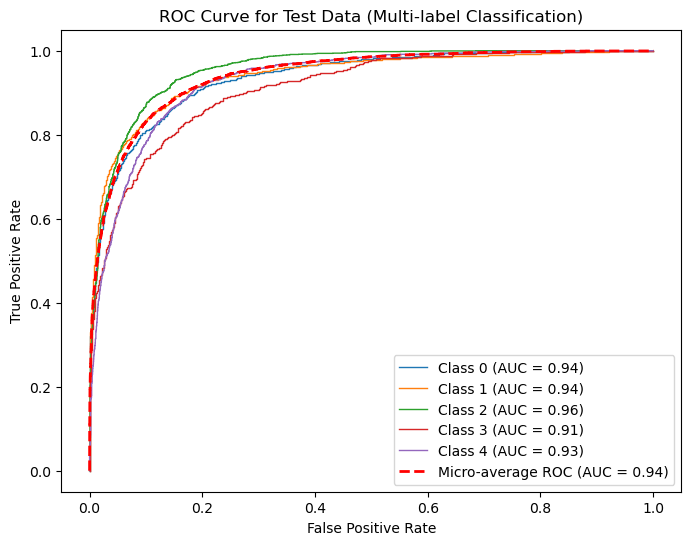

In [7]:
# 테스트 데이터 로더 정의
test_loader = DataLoader(TensorDataset(X_test.to(device).float(), y_test_tensor.to(device).float()), batch_size=batch_size, shuffle=False)

# 테스트 데이터에 대한 예측 확률 계산
model.eval()
y_scores_test = []
y_true_test = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        y_scores_test.append(output.cpu().numpy())
        y_true_test.append(batch_y.cpu().numpy())

y_scores_test = np.vstack(y_scores_test)
y_true_test = np.vstack(y_true_test)

# 각 label 별로 ROC curve 계산
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_true_test[:, i], y_scores_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# 테스트 데이터에 대한 ROC curve를 plot
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=1, label=f'Class {i} (AUC = {roc_auc_test[i]:.2f})')

# Test 데이터 전체에 대한 Micro-average ROC curve 계산 및 plot
micro_fpr_test, micro_tpr_test, _ = roc_curve(y_true_test.ravel(), y_scores_test.ravel())
micro_auc_test = auc(micro_fpr_test, micro_tpr_test)
plt.plot(micro_fpr_test, micro_tpr_test, color='red', linestyle='--', lw=2, label=f'Micro-average ROC (AUC = {micro_auc_test:.2f})')

# Labels 과 legend 추가
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data (Multi-label Classification)')
plt.legend(loc='lower right')
plt.show()

Training Fold 1...


C:\Users\ajmok\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [01:41<00:00,  4.51it/s]


Epoch 1, Average Training Loss: 0.5404
Epoch 1, Validation AUC: 0.7763


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [01:52<00:00,  4.06it/s]


Epoch 2, Average Training Loss: 0.5952
Epoch 2, Validation AUC: 0.6029


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [01:59<00:00,  3.82it/s]


Epoch 3, Average Training Loss: 0.7745
Epoch 3, Validation AUC: 0.7311


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:04<00:00,  3.68it/s]


Epoch 4, Average Training Loss: 0.6677
Epoch 4, Validation AUC: 0.6997


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:03<00:00,  3.72it/s]


Epoch 5, Average Training Loss: 0.8948
Epoch 5, Validation AUC: 0.6389


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:10<00:00,  3.51it/s]


Epoch 6, Average Training Loss: 3.1218
Epoch 6, Validation AUC: 0.5120
Early stopping at epoch 6
Best AUC: 0.7763 (Epoch 6)
Training Fold 2...


C:\Users\ajmok\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [01:57<00:00,  3.89it/s]


Epoch 1, Average Training Loss: 0.5540
Epoch 1, Validation AUC: 0.4203


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [01:59<00:00,  3.83it/s]


Epoch 2, Average Training Loss: 0.5271
Epoch 2, Validation AUC: 0.7906


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:00<00:00,  3.79it/s]


Epoch 3, Average Training Loss: 0.5208
Epoch 3, Validation AUC: 0.7040


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.77it/s]


Epoch 4, Average Training Loss: 0.5595
Epoch 4, Validation AUC: 0.7206


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.76it/s]


Epoch 5, Average Training Loss: 0.5382
Epoch 5, Validation AUC: 0.6538


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:00<00:00,  3.80it/s]


Epoch 6, Average Training Loss: 0.5402
Epoch 6, Validation AUC: 0.5164


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.76it/s]


Epoch 7, Average Training Loss: 0.5530
Epoch 7, Validation AUC: 0.6914
Early stopping at epoch 7
Best AUC: 0.7906 (Epoch 7)
Training Fold 3...


C:\Users\ajmok\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [01:57<00:00,  3.89it/s]


Epoch 1, Average Training Loss: 0.5144
Epoch 1, Validation AUC: 0.8428


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [01:58<00:00,  3.85it/s]


Epoch 2, Average Training Loss: 0.5346
Epoch 2, Validation AUC: 0.8050


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.76it/s]


Epoch 3, Average Training Loss: 0.5517
Epoch 3, Validation AUC: 0.7067


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.77it/s]


Epoch 4, Average Training Loss: 0.5263
Epoch 4, Validation AUC: 0.7527


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.75it/s]


Epoch 5, Average Training Loss: 0.6335
Epoch 5, Validation AUC: 0.7094


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.77it/s]


Epoch 6, Average Training Loss: 2.2616
Epoch 6, Validation AUC: 0.5279
Early stopping at epoch 6
Best AUC: 0.8428 (Epoch 6)
Training Fold 4...


C:\Users\ajmok\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [01:57<00:00,  3.90it/s]


Epoch 1, Average Training Loss: 0.5190
Epoch 1, Validation AUC: 0.8029


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [01:59<00:00,  3.85it/s]


Epoch 2, Average Training Loss: 0.5024
Epoch 2, Validation AUC: 0.5824


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:01<00:00,  3.78it/s]


Epoch 3, Average Training Loss: 0.5587
Epoch 3, Validation AUC: 0.6028


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:02<00:00,  3.75it/s]


Epoch 4, Average Training Loss: 0.6552
Epoch 4, Validation AUC: 0.6304


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:01<00:00,  3.76it/s]


Epoch 5, Average Training Loss: 0.4719
Epoch 5, Validation AUC: 0.8091


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:02<00:00,  3.73it/s]


Epoch 6, Average Training Loss: 0.4799
Epoch 6, Validation AUC: 0.7800


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:02<00:00,  3.73it/s]


Epoch 7, Average Training Loss: 0.6136
Epoch 7, Validation AUC: 0.6711


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:01<00:00,  3.78it/s]


Epoch 8, Average Training Loss: 0.5647
Epoch 8, Validation AUC: 0.6659


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [02:01<00:00,  3.76it/s]


Epoch 9, Average Training Loss: 0.5350
Epoch 9, Validation AUC: 0.7128


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [02:02<00:00,  3.73it/s]


Epoch 10, Average Training Loss: 0.6027
Epoch 10, Validation AUC: 0.6866
Early stopping at epoch 10
Best AUC: 0.8091 (Epoch 10)
Training Fold 5...


C:\Users\ajmok\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [01:58<00:00,  3.86it/s]


Epoch 1, Average Training Loss: 0.5222
Epoch 1, Validation AUC: 0.8123


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [01:59<00:00,  3.81it/s]


Epoch 2, Average Training Loss: 0.5513
Epoch 2, Validation AUC: 0.6155


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:02<00:00,  3.72it/s]


Epoch 3, Average Training Loss: 0.6115
Epoch 3, Validation AUC: 0.6322


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:03<00:00,  3.71it/s]


Epoch 4, Average Training Loss: 1.2603
Epoch 4, Validation AUC: 0.6897


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:02<00:00,  3.74it/s]


Epoch 5, Average Training Loss: 1.0916
Epoch 5, Validation AUC: 0.5147


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [02:01<00:00,  3.77it/s]


Epoch 6, Average Training Loss: 2.2111
Epoch 6, Validation AUC: 0.5835
Early stopping at epoch 6
Best AUC: 0.8123 (Epoch 6)


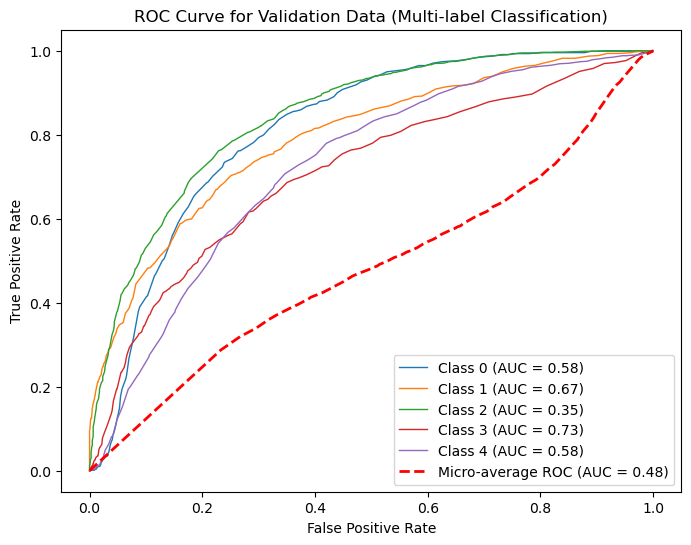

In [8]:
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub

class QuantizedCNN1D(nn.Module):
    def __init__(self, num_classes):
        super(QuantizedCNN1D, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        self.model = CNN1D(num_classes)

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

# Hyperparameters
num_classes = len(all_labels)
batch_size = 64
epochs = 30
learning_rate = 0.001
k_folds = 5

# K-Fold cross-validation initialization
skf = MultilabelStratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# ROC data lists for each label for all folds
all_fpr = []
all_tpr = []

# Early stopping parameters
patience = 5

device = 'cpu'

# Training and evaluation for each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
    print(f"Training Fold {fold + 1}...")
    
    # Initialize the model, optimizer, and loss function
    Quantized_model = QuantizedCNN1D(num_classes).to(device)
    Quantized_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(Quantized_model, inplace=True)
    
    optimizer = optim.Adam(Quantized_model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Redefine data loaders for the current fold
    train_loader = DataLoader(TensorDataset(X_train[train_idx].to(device).float(), y_train_tensor[train_idx].to(device).float()), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_train[val_idx].to(device).float(), y_train_tensor[val_idx].to(device).float()), batch_size=batch_size, shuffle=False)

    best_auc = 0.0
    no_improvement_epochs = 0

    for epoch in range(epochs):
        Quantized_model.train()
        train_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            output = Quantized_model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)
        average_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}, Average Training Loss: {average_train_loss:.4f}")

        # Validation set evaluation
        Quantized_model.eval()
        y_scores = []
        y_true = []
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                for batch_x, batch_y in val_loader:
                    output = Quantized_model(batch_x)
                    output = nn.functional.sigmoid(output)
                    y_scores.append(output.cpu().numpy())
                    y_true.append(batch_y.cpu().numpy())

        y_scores = np.vstack(y_scores)
        y_true = np.vstack(y_true)
        
        # Calculate ROC curve for each label
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            all_fpr.append(fpr[i])
            all_tpr.append(tpr[i])

        # Calculate AUC score for the validation set
        auc_score = roc_auc_score(y_true, y_scores)

        print(f"Epoch {epoch + 1}, Validation AUC: {auc_score:.4f}")

        # Check and update best AUC score
        if auc_score > best_auc:
            best_auc = auc_score
            no_improvement_epochs = 0
        else:
            # Early stopping check
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Best AUC: {best_auc:.4f} (Epoch {epoch + 1})")

# Plot ROC curves for each label
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Calculate and plot micro-average ROC curve
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
micro_auc = auc(micro_fpr, micro_tpr)
plt.plot(micro_fpr, micro_tpr, color='red', linestyle='--', lw=2, label=f'Micro-average ROC (AUC = {micro_auc:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Data (Multi-label Classification)')
plt.legend(loc='lower right')
plt.show()

In [20]:
from torchmetrics.functional import accuracy

# 이전 모델의 파라미터 수 계산
previous_model_param_count = sum(p.numel() for p in model.parameters())

# 양자화된 모델의 파라미터 수 계산
quantized_model_param_count = sum(p.numel() for p in Quantized_model.parameters())

print(f"Previous model parameter count: {previous_model_param_count}")
print(f"Quantized model parameter count: {quantized_model_param_count}")

# 모델 크기 비교
if quantized_model_param_count < previous_model_param_count:
    print("Quantized model is smaller.")
else:
    print("Quantized model is larger.")

Previous model parameter count: 614055
Quantized model parameter count: 614055
Quantized model is larger.
